# Dependency code

In [1]:
import imp
import os
import sys
import numpy as np
import glob
import cmdbench

fp, pathname, description = imp.find_module('benchmark', ['../lib'])
benchmark = imp.load_module('benchmark', fp, pathname, description)

# Summarize numpy array if it has more than 10 elements
np.set_printoptions(threshold=10)

# Software versions

In [2]:
!conda run --name snippy snippy --version

snippy 4.6.0



# Benchmarking

## Input data and constants

In [3]:
input_dir = 'input-small'
input_files_1 = [os.path.basename(f) for f in glob.glob(f'{input_dir}/*_1.fastq.gz')]
input_samples = [f.replace('_1.fastq.gz','') for f in input_files_1]
input_samples.sort()
print(input_samples)

snippy_out = 'snippy-output'
nproc = 32

reference_genome = "2011C-3609.fasta"

#sample_sizes = [1,10,20,30,40,50,60,70,80]
sample_sizes = [3]

benchmark.create_folder_if_doesnt_exist(snippy_out)
benchmark.clean_if_exists(snippy_out)

['2014C-3598', '2014C-3599', '2014C-3600', '2014C-3655', '2014C-3656', '2014C-3840', '2014C-3850', '2014C-3857', '2014C-3907', '2014D-0067', '2014D-0068', '2014D-0070', '2014D-0189', 'CFSAN000189', 'CFSAN000191', 'CFSAN000211', 'CFSAN000212', 'CFSAN000228', 'CFSAN000661', 'CFSAN000669', 'CFSAN000700', 'CFSAN000752', 'CFSAN000753', 'CFSAN000951', 'CFSAN000952', 'CFSAN000954', 'CFSAN000958', 'CFSAN000960', 'CFSAN000961', 'CFSAN000963', 'CFSAN000968', 'CFSAN000970', 'CFSAN001112', 'CFSAN001115', 'CFSAN001118', 'CFSAN001140', 'CFSAN002349', 'CFSAN023463', 'CFSAN023464', 'CFSAN023465', 'CFSAN023466', 'CFSAN023467', 'CFSAN023468', 'CFSAN023469', 'CFSAN023470', 'CFSAN023471', 'D5663', 'D7316', 'D7319', 'D7320', 'D7321', 'D7322', 'D7323', 'D7324', 'D7327', 'D7328', 'D7329', 'D7330', 'D7331', 'D7333', 'D7334', 'MOD1_LS1000', 'MOD1_LS1003', 'MOD1_LS1004', 'MOD1_LS1005', 'MOD1_LS1006', 'MOD1_LS1008', 'MOD1_LS1009', 'MOD1_LS1010', 'MOD1_LS1011', 'MOD1_LS982', 'MOD1_LS985', 'MOD1_LS989', 'MOD1_LS99

## Benchmark functions

In [4]:
def reset_func():
    benchmark.clean_if_exists(snippy_out)
    
def sampling_func(sample_size):
    samples = input_samples[:sample_size]
    
    samples_tab_file_lines = []
    
    input_dir_abs = os.path.abspath(input_dir)

    for sample in samples:
        samples_tab_file_line = f"{sample}\t{input_dir_abs}/{sample}_1.fastq.gz\t{input_dir_abs}/{sample}_2.fastq.gz"
        samples_tab_file_lines.append(samples_tab_file_line)
        
    samples_tab_file_content = "\n".join(samples_tab_file_lines)
        
    file = open(f"{snippy_out}/samples.tab", "w") 
    file.write(samples_tab_file_content + "\n")
    file.close()
    
    os.system(f"conda run --name snippy snippy-multi {snippy_out}/samples.tab --ref {input_dir_abs}/2011C-3609.fasta --cpus {nproc} > {snippy_out}/snippy-commands.sh")
    
    return samples

## Benchmark

In [5]:
snippy_multi_command = {
    "use_parallel": False,
    "command": f"conda run --name snippy cd {snippy_out}; bash snippy-commands.sh"
}

multibench_results, debug_str = benchmark.multibench.multi_cmdbench({
        "build_tree": [snippy_multi_command]
    },
    reset_func = reset_func, iterations = 1, sampling_func = sampling_func, sample_sizes = sample_sizes, 
    benchmark_list_to_results = benchmark.benchmark_list_to_results, active_output_print = True
)

>>>>>>>>>>>>>
conda run --name snippy cd snippy-output; bash snippy-commands.sh

STDOUT: 
-------------
STDERR: ERROR conda.cli.main_run:execute(32): Subprocess for 'conda run ['cd', 'snippy-output;', 'bash', 'snippy-commands.sh']' command failed.  (See above for error)
[13:49:01] This is snippy 4.6.0
[13:49:01] Written by Torsten Seemann
[13:49:01] Obtained from https://github.com/tseemann/snippy
[13:49:01] Detected operating system: linux
[13:49:01] Enabling bundled linux tools.
[13:49:01] Found bwa - /home/CSCScience.ca/apetkau/miniconda3/envs/snippy/bin/bwa
[13:49:01] Found bcftools - /home/CSCScience.ca/apetkau/miniconda3/envs/snippy/bin/bcftools
[13:49:01] Found samtools - /home/CSCScience.ca/apetkau/miniconda3/envs/snippy/bin/samtools
[13:49:01] Found java - /home/CSCScience.ca/apetkau/miniconda3/envs/snippy/bin/java
[13:49:01] Found snpEff - /home/CSCScience.ca/apetkau/miniconda3/envs/snippy/bin/snpEff
[13:49:01] Found samclip - /home/CSCScience.ca/apetkau/miniconda3/envs/snipp

# Save and reload results

In [6]:
save_path = "snippy_results.txt"

samples_per_sample_size = []
for sample_size in sample_sizes:
        samples_per_sample_size.append(input_samples[:sample_size])

benchmark.multibench.save_multibench_results(multibench_results, samples_per_sample_size, save_path)

multibench_results, samples_per_sample_size = benchmark.multibench.read_multibench_results(save_path)
print(samples_per_sample_size)

[['2014C-3598,', '2014C-3599,', '2014C-3600']]


# Plot

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

[{'runtime': 26.64, 'memory': 334987264.0, 'disk_read': 1549781204.0, 'disk_write': 570424039.0}]


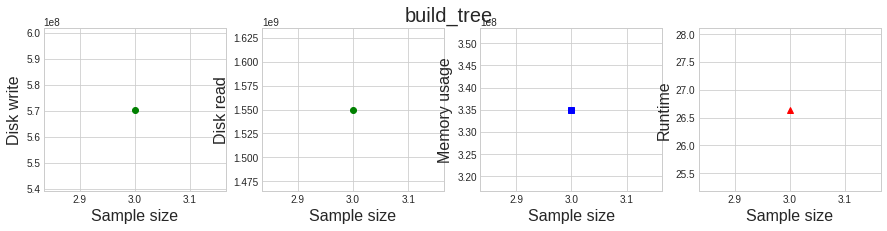

In [8]:
# Typer command Plots
benchmark.multibench.plot_resources(multibench_results, sample_sizes, "build_tree")